.. _basic_usage_tutorial:

.. currentmodule:: thunder

# Thunder context

The `ThunderContext` is the entry point for most analyses.

Setup plotting
--------------

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from thunder import Colorize
image = Colorize.image

Construction
------------
A ``ThunderContext`` (you'll only need one) is automatically provided as the variable ``tsc`` when you start the interactive shell using the command line call ``thunder``. It also be created manually, in two different ways, which can be useful when writing standalone analysis scripts (see examples in ``thunder.standalone``). First, it can be created from an existing instance of a ``SparkContext``:

In [3]:
from thunder import ThunderContext
tsc = ThunderContext(sc)

Or it can be created directly using the same arguments provided to a ``SparkContext`` (this line is commented out because executing it in the notebook will cause an error because you cannot run multiple ``SparkContexts`` at once):

In [3]:
#tsc = ThunderContext.start(appName='myapp')

Loading data
------------
The primary methods for loading data are `loadSeries` and `loadImages`, for loading a `Series` or `Images` object, respectively. Here we show example syntax for loading two example data sets included with ``thunder``, and in each case inspect the first element. (To use these example data sets, we'll first figure out their path on our system.) See the Input Format tutorial for more information on loading and data types.

In [4]:
import os.path as pth
datapath = pth.join(pth.dirname(pth.realpath(thunder.__file__)), 'utils/data/')

In [16]:
data = tsc.loadImages(datapath + '/mouse/images/', startIdx=0, stopIdx=10)

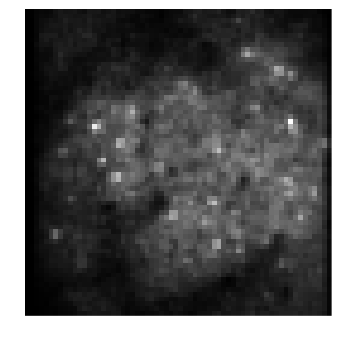

In [6]:
image(data.values().first())

In [7]:
data = tsc.loadSeries(datapath + '/iris/iris.bin', inputFormat='binary')
data.first()

((0,), array([ 5.1,  3.5,  1.4,  0.2]))

Currently, ``loadImages`` can load ``tif``, ``png``, or ``binary`` images (or volumes) from a local file system, networked file system, or Amazon S3. ``loadSeries`` can load data from one or more ``text`` or ``binary`` files on a local file system, networked file system, S3, or HDFS.

The ``loadSeries`` method can also load data stored in local arrays in either numpy ``npy`` or Matlab ``MAT`` format (if loading from a ``MAT`` file, you must additionally provide a variable name). This is not particularly useful when working with large data sets, but may be convenient for local testing, or for distributing a smaller data set for performing intensive computations. In the latter case, the number of partitions should be set to be approximately equal to 2-3 times the number of cores available on your cluster, so that different cores can work on different portions of the data.

In [8]:
data = tsc.loadSeries(datapath + '/iris/iris.mat', inputFormat='mat', varName='data', minPartitions=5)
data.first()

(0, array([ 5.1,  3.5,  1.4,  0.2]))

In [9]:
data = tsc.loadSeries(datapath + '/iris/iris.npy', inputFormat='npy', minPartitions=5)
data.first()

(0, array([ 5.1,  3.5,  1.4,  0.2]))

Finally, there are two methods for performing the common operation of converting ``Images`` data into ``Series`` data. As an example, if we have a sequence of images that represent successive time points, we might want to convert these to ``Series`` data where each record is the time series of a voxel. These two methods take a set of image files as input, and either load them directly as a ``Series``, or save the contents out as ``binary`` data suitable for loading with ``loadSeries``.

The ordering of points in the ``Series`` values comes from the lexicographic ordering of the image data file file names. Given image files that each represent a single time point, indicating the time point in the image file name so that alphabetically later file names correspond to temporally later images (for instance by adding a suffix '_tp000', '_tp001' and so on to a common file name) will result in correct ordering of the resulting ``Series`` data.

There are two implementations of the ``Image`` to ``Series`` conversion. Which to use is determined by the ``shuffle`` argument. If ``shuffle=True`` it will do the conversion using a distributed transpose operation, which requires shuffling blocks of data across the cluster. If ``shuffle=False`` it will use an alternate method that avoids the shuffle at the cost of increased file IO. In practice, ``shuffle=False`` will often be slower, but with versions of Spark before 1.2 it may be more robust.  ``shuffle=True`` is the current default.

In [17]:
data = tsc.loadImagesAsSeries(datapath + '/mouse/images/', startIdx=0, stopIdx=10)

In [ ]:
tsc.convertImagesToSeries(datapath + '/mouse/images/', 'savelocation', startIdx=0, stopIdx=10)
data = tsc.loadSeries('savelocation')

Loading examples
----------------
The `makeExample` method makes it easy to generate example data for testing purposes, by calling methods from the `DataSets` class:

In [22]:
data = tsc.makeExample('kmeans', k=2, ndims=10, nrecords=10, noise=0.5)

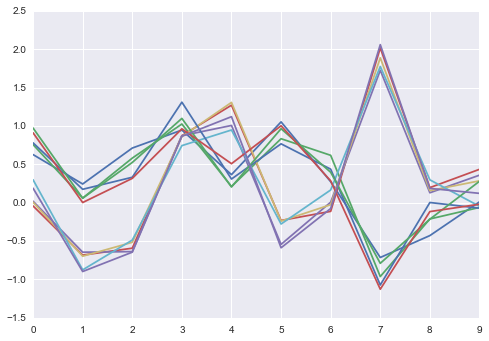

In [23]:
from numpy import asarray
ts = data.collectValuesAsArray()
plt.plot(ts.T);

The 'loadExample' method directly loads one of the small example datasets. This are highly compressed and downsampled, and meant only to demonstrate basic functionality and help explore the API, not to represent anything meaningful about the data itself.

In [24]:
data = tsc.loadExample('mouse-images')
img = data[0]

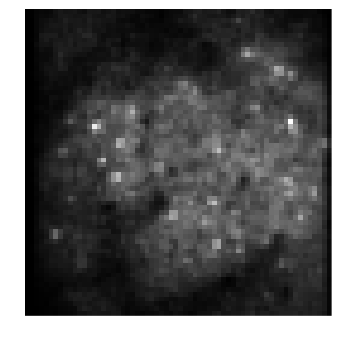

In [25]:
image(img)

In [28]:
data = tsc.loadExample('fish-series')
img = data.seriesMean().pack()

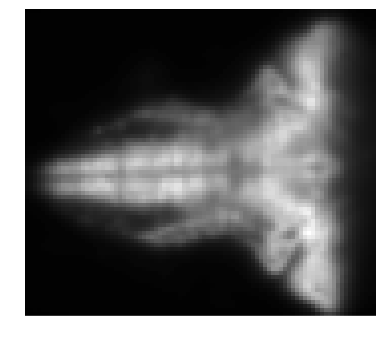

In [29]:
image(img[:,:,0])

You can easily see the list of avaiable example data sets:

In [30]:
tsc.loadExample()

['fish-images',
 'fish-series',
 'iris',
 'mouse-images',
 'mouse-params',
 'mouse-series']

Example data stored on S3 can be loaded using the ``loadExampleEC2`` method. You must be running Thunder on an Amazon EC2 cluster in order to use these methods. Some of the available data sets include parameters that are returned alongside the data, as in

In [ ]:
data, params = tsc.loadExampleS3('zebrafish-optomotor-response')

You can also check the available data sets:

In [18]:
tsc.loadExampleS3()

['ahrens.lab/optomotor.response',
 'ahrens.lab/direction.selectivity',
 'svoboda.lab/tactile.navigation']